In [72]:
import scipy as sp
import numpy as np
import qibo
from qibo.symbols import *
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import unitary_group

from functions import *

In [3]:
def decomposeInEigenBasis(eigenvectors, state):
    n = len(eigenvectors)
    coeff = np.zeros(n, dtype = complex)
    for i in range(n):
        coeff[i] = state.conj().T @ eigenvectors[:,i]
    return coeff

In [4]:
def entropy(p):
    return -np.sum(p*np.log(p))

def qEntropy(rho):
    return -np.real(np.trace(rho @ sp.linalg.logm(rho)))

def freeEnergy(T, E, p):
    return E - T * entropy(p)

def qfreeEnergy(T, H, rho):
    return np.real(np.trace(rho @ H)) - T * qEntropy(rho)

def freeEnergyLowerBound(T, H, rho):
    N = len(rho)
    return np.real(np.trace(rho @ H)) + T * np.log(1/N)

def freeEnergyUpperBound(T, E, p0):
    return E + T * np.log(p0)




In [5]:
def probDistribution(energies, T):
    p = np.empty(len(energies))
    for i in range(len(energies)):
        p[i] = np.exp(-energies[i]/T)
    return p/np.sum(p)

def skewness(H, V, rho):
    """
    Skewness of the Hamiltonian in the state.
    """
    E = energy(H, rho)
    val1 = energy(H@H@H, rho)
    val2 = -3*E*energy(H@H, rho)
    val3 = 2*E**3

    return (val1+val2+val3)/V**(3/2)

def optimalEnergyStepRho(H,  rho):
    """
    Optimal step size at an iteration for minimizing the energy.
    """
    V = np.real(np.trace(rho @ H @ H)) - np.real(np.trace(rho @ H))**2
    S = skewness(H, V, rho)
    alpha = np.arccos(1/(np.sqrt(1+0.25*S**2)))
    sOpt = (np.pi-2*alpha)/(4*np.sqrt(V))
    return sOpt

def prob(H, rho, s, T):
    energies = np.linalg.eigvalsh(H)
    energyExpectation = energy(H, rho)
    variance =  np.real(np.trace(H@H@rho)) - energyExpectation**2
    a = energyExpectation/np.sqrt(variance)*np.sin(s*np.sqrt(variance))+np.cos(s*np.sqrt(variance))
    b = -1/np.sqrt(variance)*np.sin(s*np.sqrt(variance))
    p = (a + b*energies)**2 * np.exp(-energies/T)
    Z = np.sum(np.exp(-energies/T)) 
    return p/Z

def effectiveEntropy(H, rho, s, T):
    energies = np.linalg.eigvalsh(H)
    energyExpectation = energy(H, rho)
    variance =  np.real(np.trace(H@H@rho)) - energyExpectation**2
    a = energyExpectation/np.sqrt(variance)*np.sin(s*np.sqrt(variance))+np.cos(s*np.sqrt(variance))
    b = -1/np.sqrt(variance)*np.sin(s*np.sqrt(variance))
    p = (a + b*energies)**2 * np.exp(-energies/T)
    Z = np.sum(np.exp(-energies/T))
    p = p/Z
    return np.sum(p*np.log((a+b*energies)**2))

[Qibo 0.2.16|INFO|2025-03-26 10:54:40]: Using numpy backend on /CPU:0
[Qibo 0.2.16|WARNING|2025-03-26 10:54:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


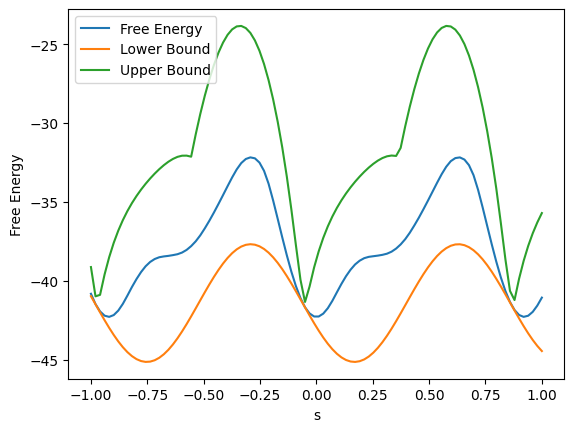

In [8]:
nqubits = 6
H_def = sum([X(x+1)*X(x)+Y(x+1)*Y(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H)
H = np.diag(eigenvalues)

T = 10
p = probDistribution(eigenvalues, T)
rho = np.diag(p)

s = np.linspace(-1, 1, 100)
F = np.zeros(len(s))
F2 = np.zeros(len(s))
F_lower = np.zeros(len(s))
F_upper = np.zeros(len(s))
for i in range(len(s)):
    p = prob(H, rho, s[i], T)
    rho2 = np.diag(p)
    F[i] = freeEnergy(T, energy(H, rho2), p)
    F_lower[i] = freeEnergyLowerBound(T, H, rho2)
    F_upper[i] = freeEnergyUpperBound(T, energy(H, rho2), np.max(p))

plt.figure()
plt.plot(s, F, label = 'Free Energy')
plt.plot(s, F_lower, label = 'Lower Bound')
plt.plot(s, F_upper, label = 'Upper Bound')
plt.xlabel('s')
plt.ylabel('Free Energy')
plt.legend()



In [12]:
def dbi(s, H, rho):
    C = commutator(rho, H)
    U = sp.linalg.expm(s*C)
    rho2 = U @ rho @ U.conj().T
    return rho2

In [13]:
def dbiState(s,H,state):
    rho = np.outer(state,state.conj())    
    C = commutator(rho, H)
    U = sp.linalg.expm(s*C)
    result = U @ state
    return result

def dbi2(s,H,state):
    energy = state.conj().T @ H @ state
    variance = state.conj().T @ H @ H @ state - energy**2
    a = energy/np.sqrt(variance)*np.sin(s*np.sqrt(variance))+np.cos(s*np.sqrt(variance))
    b = -1/np.sqrt(variance)*np.sin(s*np.sqrt(variance))
    result = (a*state+b*H@state)
    return result

In [7]:
def partial_trace(rho, nqubits, keep=0):

    d = 2 ** (nqubits // 2)  # Dimension of each subsystem
    rho = rho.reshape([d, d, d, d])  # Reshape into a 4D tensor

    if keep == 0:  # Trace out the second subsystem (B)
        return np.trace(rho, axis1=1, axis2=3)  # Partial trace over B
    else:  # Trace out the first subsystem (A)
        return np.trace(rho, axis1=0, axis2=2)  # Partial trace over A


In [ ]:
# def sTest(rho, H):
#     E = energy(H, rho)
#     V = np.real(np.trace(rho @ H @ H)) - E**2
#     M3 = np.real(np.trace(rho @ H @ H @ H)) - 3*np.real(np.trace(rho @ H @ H)) * E + 2*E**3
#     M4 = np.real(np.trace(rho @ H @ H @ H @ H)) - 4*np.real(np.trace(rho @ H @ H @ H)) * E + 6*np.real(np.trace(rho@H@H))*E**2 - 3*np.real(np.trace(rho @ H))**4
#     a = 4*(M4-19/3*V**2)
#     b = -12*M3
#     c = 8*V
#     disc = b**2 - 4*a*c
#     s = (-b + np.sqrt(disc))/(2*a)
#     return s

# def sTest2(rho, H):
#     V = np.real(np.trace(rho @ H @ H)) - np.real(np.trace(rho @ H))**2
#     M3 = np.real(np.trace(rho @ H @ H @ H)) - 3*np.real(np.trace(rho @ H @ H)) * np.real(np.trace(rho @ H)) + 2*np.real(np.trace(rho @ H))**3
#     s = 2*V/(3*M3)
#     return s
# def sTest3(rho,H):
#     E = energy(H, rho)
#     V = np.real(np.trace(rho @ H @ H)) - E**2
#     theta = np.arctan(V/E)
#     s = (3*np.pi-2*theta)/(2*np.sqrt(V))
#     return s

def sTest (rho,H, T, T0):
    E = energy(H, rho)
    V = np.real(np.trace(rho @ H @ H)) - E**2
    M3 = np.real(np.trace(rho @ H @ H @ H)) - 3*np.real(np.trace(rho @ H @ H)) * E + 2*E**3
    alpha = (T0-T)/T0
    s = alpha*V/(alpha*(M3+E*V) + T*V)
    return s

def sTest2 (rho, H, T, T0):
    E = energy(H, rho)
    V = np.real(np.trace(rho @ H @ H)) - E**2
    M3 = np.real(np.trace(rho @ H @ H @ H)) - 3*np.real(np.trace(rho @ H @ H)) * E + 2*E**3
    alpha = (T0-T)/T0
    a = (M3+E*V/2)*alpha  +5*T*V/2
    b = -2*alpha*V
    return -b/(2*a)
    # num = V*alpha-E+1
    # den = alpha*(M3+E*V/2)+5/2*V*T
    # return num/den

def polynomial(rho, H, T, T0, s):
    E = energy(H, rho)
    V = np.real(np.trace(rho @ H @ H)) - E**2
    M3 = np.real(np.trace(rho @ H @ H @ H)) - 3*np.real(np.trace(rho @ H @ H)) * E + 2*E**3
    alpha = (T0-T)/T0
    a = (M3+E*V/2)*alpha  +5*T*V/2
    b = -2*alpha*V
    c = alpha*E
    return a*s**2 + b*s + c

def polynomial2(rho, H, s):
    E = energy(H, rho)
    V = np.real(np.trace(rho @ H @ H)) - E**2
    a = 5/2*V
    b = 0
    c = 0
    return a*s**2 + b*s + c

[Qibo 0.2.16|WARNING|2025-04-02 14:28:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


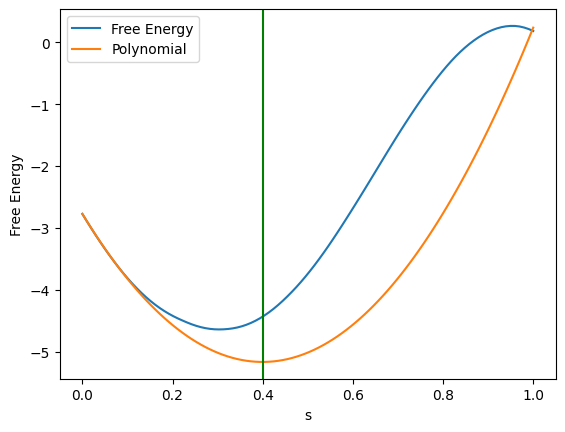

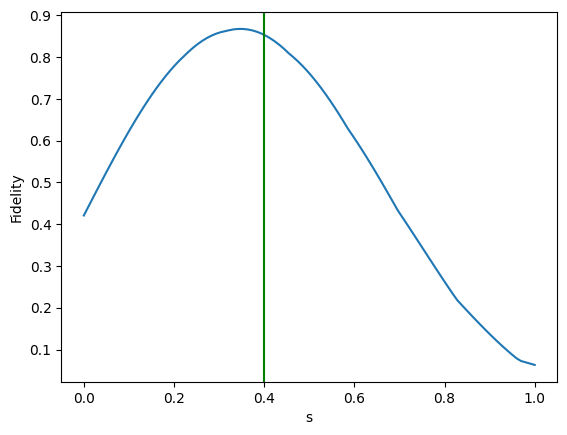

In [71]:
nqubits = 4
#H_def = sum([Z(x+1)*Z(x)+X(x)+X(x+1)+Y(x)*Y(x+1)   for x in range(nqubits-1)])
H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H1)
H = np.kron(H1, np.eye(2**nqubits))
energies = np.linalg.eigvalsh(H)

T0 = 1000
coeffs = np.empty(2**nqubits)
for i in range(2**nqubits):
    coeffs[i] = np.exp(-0.5*eigenvalues[i]/T0)
state = tfd0(nqubits)

rho0 = np.outer(state, state.conj())
T = 1
rhoTarget = sp.linalg.expm(-H1/T) / np.trace(sp.linalg.expm(-H1/T))
s = np.linspace(0, 1, 100)
E = np.zeros(len(s))
E2 = np.zeros(len(s))
F = np.zeros(len(s))
F2 = np.zeros(len(s))
eff = np.zeros(len(s))
fidelity = np.zeros(len(s))
poly = np.zeros(len(s))
for i in range(len(s)):
    rho2 = dbi(s[i], H, rho0)
    rhoA = partial_trace(rho2, 2*nqubits, keep=0)
    eigenvalues = np.linalg.eigvalsh(rhoA)
    E[i] = energy(H, rho2)
    E2[i] = energy(H1, rhoA)
    F[i] = qfreeEnergy(T, H1, rhoA)
    rhoA = partial_trace(rho0, 2*nqubits, keep=0)
    partition = np.sum(np.exp(-eigenvalues/T0))
    poly[i] = polynomial(rhoA, H1, T, T0, s[i]) -T*np.log(partition)
    p = prob(H1, rhoA, s[i], T0)
    F2[i] = freeEnergy(T, E2[i], p)
    rhoA = partial_trace(rho2, 2*nqubits, keep=0)
    fidelity[i] = np.real(np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rhoA)@rhoTarget@sp.linalg.sqrtm(rhoA)))**2)

rhoA = partial_trace(rho0, 2*nqubits, keep=0)
#sOpt = optimalEnergyStep(H, state)
sT = sTest2(rhoA, H1, T , T0)
# plt.figure()
# plt.plot(s, E, label = 'Entire Energy')
# plt.plot(s, E2, '--', label = 'System A Energy')
# plt.xlabel('s')
# plt.ylabel('Energy')
# #plt.axvline(x = sOpt, color = 'r')
# plt.legend()
# plt.show()

#sFreeEnergy = s[np.argmin(F)]
plt.figure()
#plt.plot(s, F)
plt.plot(s,F2, label = 'Free Energy')
plt.plot(s, poly, label = 'Polynomial')
plt.xlabel('s')
plt.ylabel('Free Energy')
#plt.axvline(x = sFreeEnergy, color = 'r')
plt.axvline(x = sT, color = 'g')
plt.legend()
#plt.show()

plt.figure()
plt.plot(s, fidelity)
plt.xlabel('s')
plt.ylabel('Fidelity')
plt.axvline(x = sT, color = 'g')




# plt.figure()
# plt.plot(s, eff)
# plt.plot(s,poly2)
# plt.xlabel('s')
# plt.ylabel('Effective Entropy')
# plt.show()




[Qibo 0.2.16|WARNING|2025-04-02 14:22:43]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


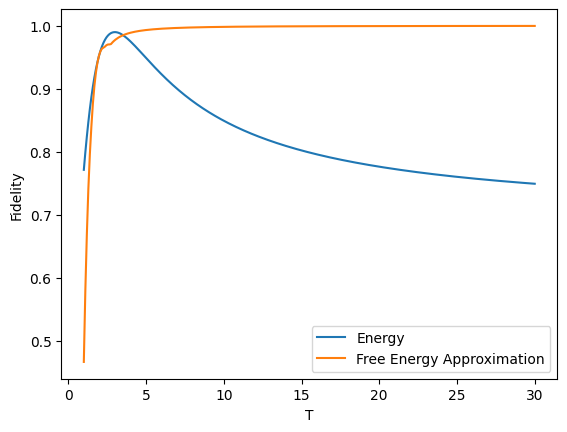

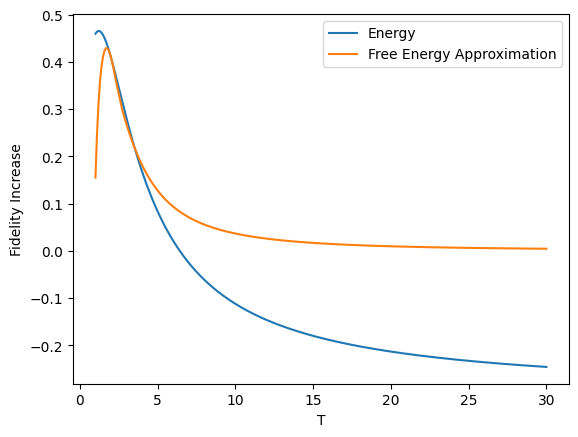

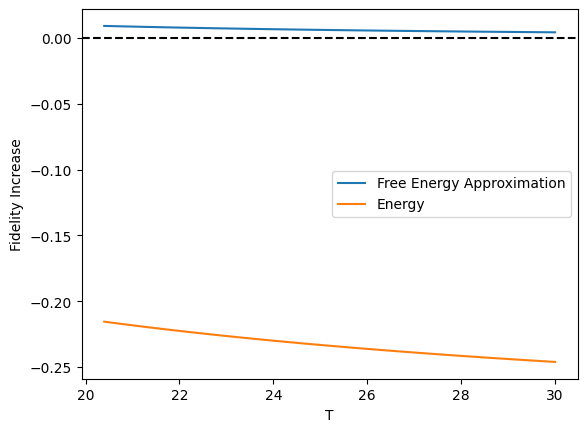

In [58]:
nqubits = 4
H_def = sum([Z(x+1)*Z(x)+X(x)+X(x+1)+Y(x)*Y(x+1)   for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H1)
H = np.kron(H1, np.eye(2**nqubits))
energies = np.linalg.eigvalsh(H1)

T0 = 1000
coeffs = np.empty(2**nqubits)
for i in range(2**nqubits):
    coeffs[i] = np.exp(-0.5*eigenvalues[i]/T0)
state = maxEntangledState(nqubits, eigenvectors, coeffs)

rho0 = np.outer(state, state.conj())
rho0A = partial_trace(rho0, 2*nqubits, keep=0)
T = np.linspace(1, 30, 300)

fidelityE = np.zeros(len(T))
fidelityS = np.zeros(len(T))
fidelity0 = np.zeros(len(T))
sE = optimalEnergyStepRho(H1, rho0A)
rhoE = dbi(sE, H, rho0)
rhoE_A = partial_trace(rhoE, 2*nqubits)

for i in range(len(T)):
    rhoTarget = sp.linalg.expm(-H1/T[i]) / np.trace(sp.linalg.expm(-H1/T[i]))
    fidelity0[i] = np.real(np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rho0A)@rhoTarget@sp.linalg.sqrtm(rho0A)))**2)
    fidelityE[i] = np.real(np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rhoE_A)@rhoTarget@sp.linalg.sqrtm(rhoE_A)))**2)
    s = sTest2(rho0A, H1, T[i], T0)
    rho2 = dbi(s, H, rho0)
    rhoA = partial_trace(rho2, 2*nqubits)
    fidelityS[i] = np.real(np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rhoA)@rhoTarget@sp.linalg.sqrtm(rhoA)))**2)
                                                    

plt.figure()
plt.plot(T,fidelityE, label = 'Energy')
plt.plot(T, fidelityS, label = 'Free Energy Approximation')
plt.xlabel('T')
plt.ylabel('Fidelity')
plt.legend()

plt.figure()
plt.plot(T, fidelityE-fidelity0, label = 'Energy')
plt.plot(T, fidelityS-fidelity0, label = 'Free Energy Approximation')
plt.xlabel('T')
plt.ylabel('Fidelity Increase')
plt.legend()

plt.figure()
plt.plot(T[200:], (fidelityS-fidelity0)[200:], label = 'Free Energy Approximation')
plt.plot(T[200:], (fidelityE-fidelity0)[200:], label = 'Energy')
plt.axhline(y=0, color = 'k', linestyle = '--')
plt.xlabel('T')
plt.ylabel('Fidelity Increase')
plt.legend()


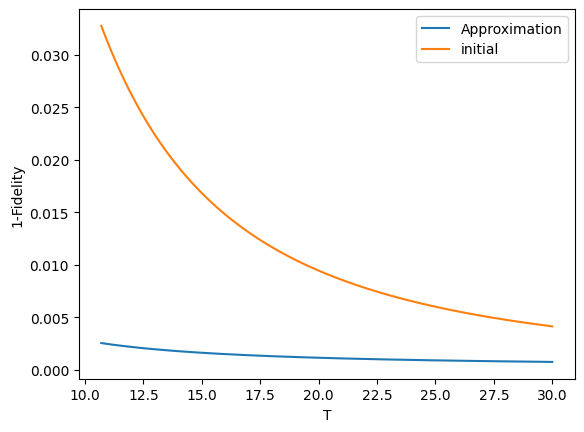

In [57]:

plt.figure()
plt.plot(T[100:], 1-fidelityS[100:], label = 'Approximation')
plt.plot(T[100:], 1-fidelity0[100:], label = 'initial')
plt.xlabel('T')
plt.ylabel('1-Fidelity')
plt.legend()


In [16]:
H = (Z(0)*Z(2)+X(0)*X(2)+Y(0)*Y(2) + Z(1)*Z(3)+X(1)*X(3)+Y(1)*Y(3))
H = hamiltonians.SymbolicHamiltonian(H).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H)
print(eigenvalues)
print(eigenvectors[:,0])

[Qibo 0.2.16|WARNING|2025-03-26 10:54:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[-6. -2. -2. -2. -2. -2. -2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
[-0.00000000e+00+0.j -0.00000000e+00+0.j -0.00000000e+00+0.j
 -5.00000000e-01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  5.00000000e-01+0.j  0.00000000e+00+0.j -3.35039435e-17+0.j
  5.00000000e-01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -5.00000000e-01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
 -0.00000000e+00+0.j]


In [17]:
state00 = np.array([1,0,0,0])
state01 = np.array([0,1,0,0])
state10 = np.array([0,0,1,0])
state11 = np.array([0,0,0,1])

bell = (np.kron(state00,state11) + np.kron(state11,state00))/2
bell -= (np.kron(state01,state10) + np.kron(state10,state01))/2

E = energy(H, bell)
print(E)
bell

-6.0


array([ 0. ,  0. ,  0. ,  0.5,  0. ,  0. , -0.5,  0. ,  0. , -0.5,  0. ,
        0. ,  0.5,  0. ,  0. ,  0. ])

In [18]:
nqubits = 2
H_def = -X(0)*X(1)-Y(0)*Y(1)
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
Htest = np.kron(H1, np.eye(2**nqubits))
eigenvalues, eigenvectors = np.linalg.eigh(Htest)
state = Htest@bell
coeff = decomposeInEigenBasis(eigenvectors, state)
print(coeff)

[Qibo 0.2.16|WARNING|2025-03-26 10:54:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[ 0.        +0.j -0.70710678+0.j -0.70710678+0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
 -0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]


In [10]:
def countOnes(n):
    binary = bin(n)
    count = 0
    for i in range(len(binary)):
        if binary[i] == '1':
            count += 1
    return count

def tfd0(n):
    tfd = np.zeros(2**(2*n))
    for i in range(2**n):
        state = np.zeros(2**n)
        state[i] = 1
        state2 = np.zeros(2**n)
        state2[2**n-1-i] = 1
        ones = countOnes(i)
        if ones%2 == 0:
            sign = 1
        else:
            sign = -1

        tfd += sign*np.kron(state, state2)
    return tfd/np.sqrt(2**n)    

In [20]:
nqubits = 4
H_def = sum([Z(x)*Z(nqubits+x)+X(x)*X(nqubits+x)+Y(x)*Y(nqubits+x)   for x in range(nqubits)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
state = tfd0(nqubits)
eigenvalues, eigenvectors = np.linalg.eigh(H)
E = energy(H, state)
print(E-eigenvalues[0])

[Qibo 0.2.16|WARNING|2025-03-26 10:54:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0.0


[Qibo 0.2.16|WARNING|2025-04-02 13:28:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


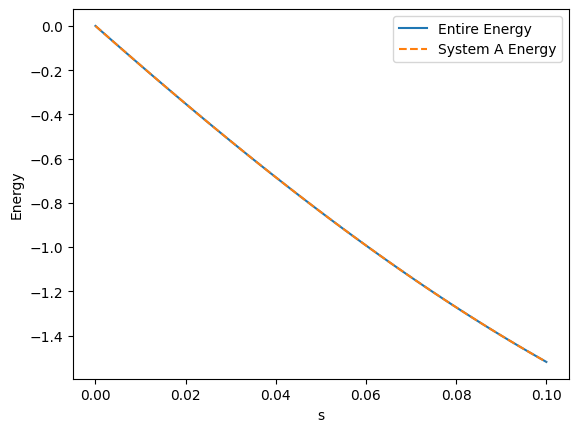

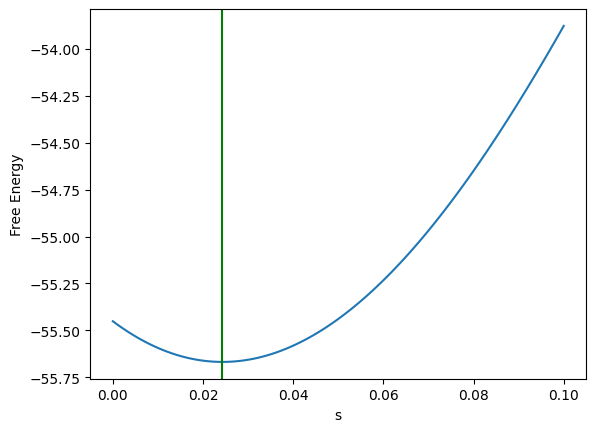

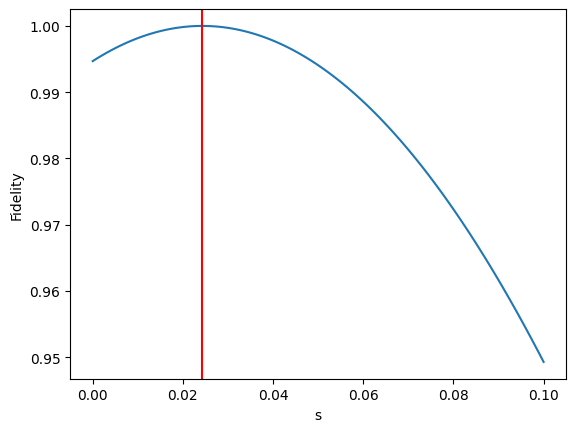

In [22]:
nqubits = 4
H_def = sum([X(x+1)*X(x)+Y(x+1)*Y(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H1)
H = np.kron(H1, np.eye(2**nqubits))
energies = np.linalg.eigvalsh(H)

T0 = 1000
state = tfd0(nqubits)

rho0 = np.outer(state, state.conj())
T = 20
rhoTarget = sp.linalg.expm(-H1/T) / np.trace(sp.linalg.expm(-H1/T))
s = np.linspace(0.0, 0.1, 100)
E = np.zeros(len(s))
E2 = np.zeros(len(s))
F = np.zeros(len(s))
F2 = np.zeros(len(s))
fidelity = np.zeros(len(s))
poly = np.zeros(len(s))
for i in range(len(s)):
    rho2 = dbi(s[i], H, rho0)
    rhoA = partial_trace(rho2, 2*nqubits, keep=0)
    eigenvalues = np.linalg.eigvalsh(rhoA)
    E[i] = energy(H, rho2)
    E2[i] = energy(H1, rhoA)
    F[i] = qfreeEnergy(T, H1, rhoA)
    rhoA = partial_trace(rho0, 2*nqubits, keep=0)
    partition = np.sum(np.exp(-eigenvalues/T0))
    #poly = polynomial(rhoA, H1, T, T0) -T*np.log(partition)
    p = prob(H1, rhoA, s[i], T0)
    F2[i] = freeEnergy(T, E2[i], p)
    rhoA = partial_trace(rho2, 2*nqubits, keep=0)
    fidelity[i] = np.real(np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rhoA)@rhoTarget@sp.linalg.sqrtm(rhoA)))**2)

#sOpt = optimalEnergyStep(H, state)
sT = s[np.argmin(F)]
plt.figure()
plt.plot(s, E, label = 'Entire Energy')
plt.plot(s, E2, '--', label = 'System A Energy')
plt.xlabel('s')
plt.ylabel('Energy')
#plt.axvline(x = sOpt, color = 'r')
plt.legend()
plt.show()

#sFreeEnergy = s[np.argmin(F)]
plt.figure()
plt.plot(s, F)
#plt.plot(s,F2 , '--')
#plt.plot(s, poly, '--')
plt.xlabel('s')
plt.ylabel('Free Energy')
#plt.axvline(x = sFreeEnergy, color = 'r')
plt.axvline(x = sT, color = 'g')
plt.show()

plt.figure()
plt.plot(s, fidelity)
plt.xlabel('s')
plt.ylabel('Fidelity')
plt.axvline(x = sT, color = 'r')



In [16]:
def qfreeEnergyMin(s, T, H, H1, rho, nqubits):
    rhoNew = dbi(s, H, rho)
    rhoNew = partial_trace(rhoNew, 2*nqubits, keep=0)
    return np.real(np.trace(rhoNew @ H1)) - T * qEntropy(rhoNew)

def qfreeEnergyDeriv(s, rho, H, H1, T, nqubits):
    W = commutator(rho, H)
    rhoNew = dbi(s, H, rho)
    dRho = commutator(W, rhoNew)
    rhoNew = partial_trace(rhoNew, 2*nqubits, keep=0)
    dRho = partial_trace(dRho, 2*nqubits, keep=0)
    return np.real(np.trace(dRho @ H1)) + T * np.real(np.trace(dRho@(np.eye(2**nqubits)+sp.linalg.logm(rhoNew))))

def qfreeEnergyDeriv2(s, rho, H, H1, T, nqubits):
    W = commutator(rho, H)
    rhoNew = dbi(s, H, rho)
    dRho = commutator(W, rhoNew)
    dRho2 = commutator(W, dRho)
    rhoNew = partial_trace(rhoNew, 2*nqubits, keep=0)
    dRho = partial_trace(dRho, 2*nqubits, keep=0)
    dRho2 = partial_trace(dRho2, 2*nqubits, keep=0)
    rhoInv = sp.linalg.inv(rhoNew)
    return np.real(np.trace(dRho2 @ H1)) + T * np.real(np.trace(dRho2@(np.eye(2**nqubits)+sp.linalg.logm(rhoNew))+dRho@dRho@rhoInv))

def getItersFreeEnergy(beta, H, H1, epsilon, nqubits, iters2 = 100):
    initState = tfd0(nqubits)
    rho = np.outer(initState, initState.conj())
    targetState = sp.linalg.expm(-beta/2*H)@initState
    targetState /= np.linalg.norm(targetState)
    iters = 0
    fidelity = Fidelity(initState, targetState)
    error = 1-fidelity
    state = np.copy(initState)
    while error > epsilon:
        rho = np.outer(state, state.conj())
        def objective(s):
            return qfreeEnergyMin(s, 1/beta, H, H1, rho, nqubits)   
        
        res = sp.optimize.minimize_scalar(
            objective,
            bounds=(0, 0.3), 
            method='bounded',
            options={'xatol': 1e-12}
            
        )
        s_opt = res.x
        state = dbiState(s_opt, H, state)
        iters += 1
        fidelity = Fidelity(state, targetState)
        error = 1-fidelity
        if iters > iters2:
            break
    return iters


[Qibo 0.2.16|WARNING|2025-04-02 14:02:27]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


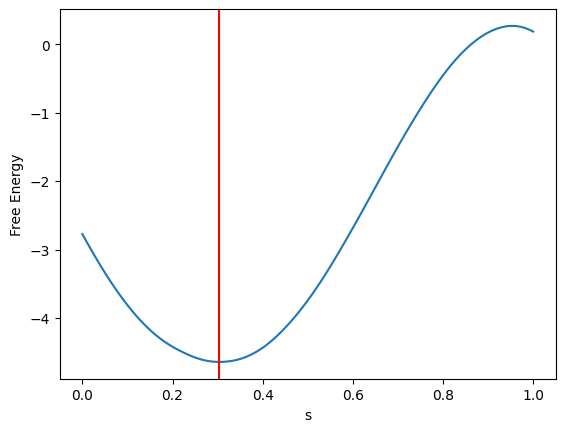

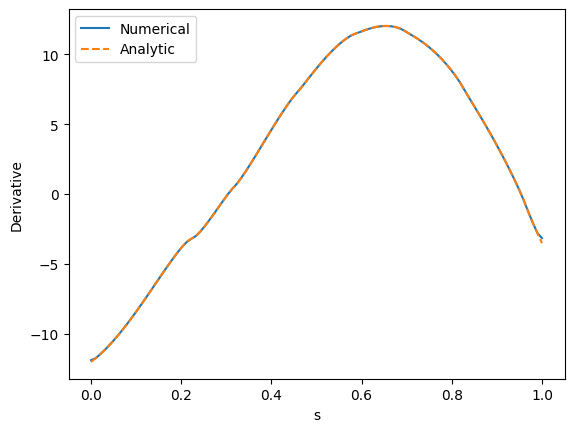

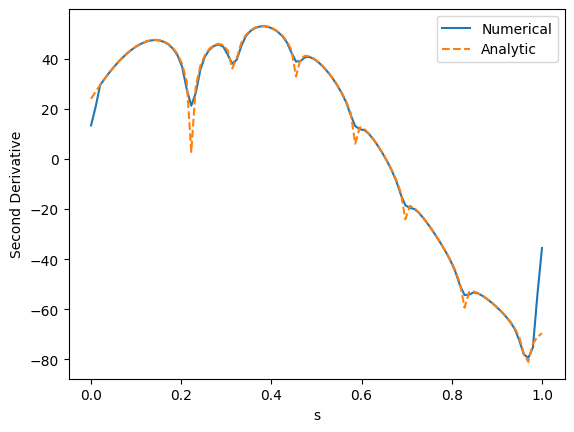

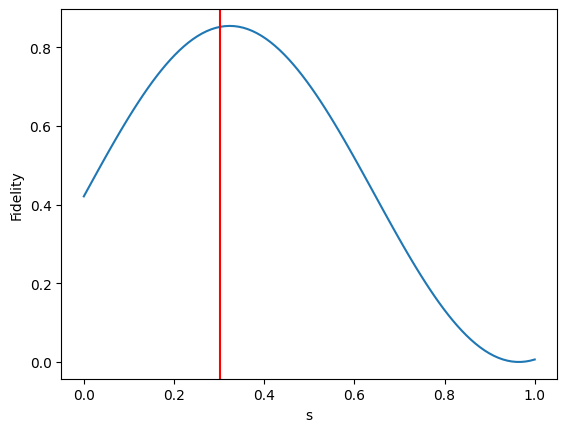

In [24]:
beta = 1
nqubits = 4
H_def = sum([X(x)-Z(x+1)*Z(x)   for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
H = np.kron(H1, np.eye(2**nqubits))

initState = tfd0(nqubits)
rho = np.outer(initState, initState.conj())
targetState = sp.linalg.expm(-beta/2*H)@initState
targetState /= np.linalg.norm(targetState)
s = np.linspace(0, 1, 100)

F = np.zeros(len(s))
derivative = np.zeros(len(s))
derivative2 = np.zeros(len(s))
error = np.zeros(len(s))
for i in range(len(s)):
    state = dbiState(s[i], H, initState)
    rho2 = np.outer(state, state.conj())
    rhoA = partial_trace(rho2, 2*nqubits, keep=0)
    F[i] = qfreeEnergy(1/beta, H1, rhoA)
    derivative[i] = qfreeEnergyDeriv(s[i], rho, H, H1, 1/beta, nqubits)
    derivative2[i] = qfreeEnergyDeriv2(s[i], rho, H, H1, 1/beta, nqubits)
    fidelity = Fidelity(state, targetState)
    error[i] = fidelity


plt.figure()
plt.plot(s, F)
plt.xlabel('s')
plt.ylabel('Free Energy')
plt.axvline(x = s[np.argmin(F)], color = 'r')
plt.show()

plt.figure()
plt.plot(s, np.gradient(F,s), label = 'Numerical')
plt.plot(s, derivative,'--', label = 'Analytic')
plt.xlabel('s')
plt.ylabel('Derivative')
plt.legend()

plt.figure()
plt.plot(s, np.gradient(np.gradient(F,s), s), label = 'Numerical')
plt.plot(s, derivative2, '--', label = 'Analytic')
plt.xlabel('s')
plt.ylabel('Second Derivative')
plt.legend()

plt.figure()
plt.plot(s, error)
plt.xlabel('s')
plt.ylabel('Fidelity')
plt.axvline(x = s[np.argmin(F)], color = 'r')
plt.show()



[Qibo 0.2.16|WARNING|2025-04-01 15:48:52]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


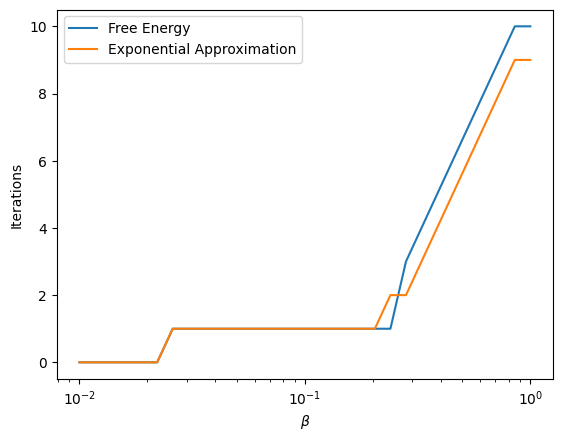

In [62]:
beta = np.logspace(-2, 0, 30)
nqubits = 3
H_def = sum([Z(x+1)*Z(x)+Y(x+1)*Y(x)+X(x+1)*X(x)  for x in range(nqubits-1)])
H1 = hamiltonians.SymbolicHamiltonian(H_def).matrix
H = np.kron(H1, np.eye(2**nqubits))

iters = np.zeros(len(beta))
iters2 = np.zeros(len(beta))
for i in tqdm(range(len(beta))):
    iters2[i] = thermalStatePrepKNumbers(beta[i], 1e-3, H, nqubits, 'DBI', K = 0)
    iters[i] = getItersFreeEnergy(beta[i], H, H1, 1e-3, nqubits, iters2[i])
    

plt.figure()
plt.plot(beta, iters, label ="Free Energy")
plt.plot(beta, iters2, label = "Exponential Approximation")
plt.xscale('log')
plt.xlabel(r'$\beta$')
plt.ylabel('Iterations')
plt.legend()

plt.show()
